In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
data_path = pd.read_csv(
    "/Users/mxposed/Documents/data_paths/ssc.csv",
    index_col=0
).value["clinical_data"]

In [4]:
data_path = os.path.join(data_path, "processed")

In [5]:
os.makedirs("plots", exist_ok=True)

# Plot timeline for clinical data

We want to plot patients' timeline for our dataset to contextualize different measurements that we have.

We will anchor timeline relative to date of bronchoscopy (BAL collection).

**NB**: for patients with 2 BALs, we make first BAL day 0, for patients with 2 BALs where we only have the second, we will make the second one day 0

## 1. Load sample and timeline data

In [6]:
samples = pd.read_csv("../00all-samples.csv")

Take only our samples

In [7]:
samples = samples.loc[samples.Study.eq("this"), :].copy()

In [8]:
samples["Patient_id"] = samples.Sample

Strip `_followup` to get Redcap patient ids

In [9]:
samples.Patient_id = samples.Patient_id.str.replace("_followup$", "", regex=True)

Number of unique patients among our samples

In [10]:
samples.Patient_id.nunique()

14

In [11]:
pt_info = pd.read_csv(os.path.join(data_path, "01_pt_info.csv"), index_col=0)

In [12]:
date_info = pd.read_csv(os.path.join(data_path, "05_date_info.csv"), index_col=0)

In [13]:
date_info.date = pd.to_datetime(date_info.date)

In [14]:
disease_info = pd.read_csv(os.path.join(data_path, "02_disease_info.csv"), index_col=0)

## 2. Determine day-0 BAL per patient

In [15]:
bronchs = date_info.loc[date_info.event.eq("bronch_date")].copy()

In [16]:
bronchs["Sample"] = bronchs.study_code

In [17]:
bronchs.loc[bronchs.redcap_event_name.eq("follow_up_arm_1"), "Sample"] += "_followup"

In [18]:
bronchs = bronchs.merge(samples, on="Sample")

In [19]:
bronchs.sort_values("date", inplace=True)

In [20]:
day0_dates = bronchs.groupby("study_code").head(1)[
    ["study_code", "date"]
].set_index("study_code").date

## 3. Make all other dates relative per patient

In [21]:
def relative_date_per_pt(row):
    return (row.date - day0_dates[row.study_code]).days

date_info["date_rel"] = date_info.apply(relative_date_per_pt, axis=1)

In [22]:
date_info["disease"] = disease_info[
    ["study_code", "disease"]
].set_index("study_code").disease[date_info.study_code].values

In [23]:
date_info.disease = pd.Categorical(date_info.disease, categories=["control", "SSc"])

In [24]:
date_info.study_code = pd.Categorical(date_info.study_code)

In [25]:
date_info.sort_values(["disease", "study_code", "date"], inplace=True)

Remove bronchs that have no samples

In [26]:
bronchs_to_keep = date_info.loc[date_info.event.eq('bronch_date')].reset_index(names='idx').merge(
    bronchs,
    on=['study_code', 'date']
).idx

In [27]:
date_info = date_info.loc[date_info.event.ne('bronch_date') | date_info.index.isin(bronchs_to_keep)]

## 4. Verify control patients only have 1 day-0 event

So, do not plot them

In [28]:
assert np.all(date_info.date_rel[date_info.disease.eq("control")].eq(0))

In [29]:
date_info = date_info.loc[date_info.disease.ne("control"), :].copy()

In [30]:
date_info.study_code = date_info.study_code.cat.remove_unused_categories()

## 5. Plot

In [31]:
EVENT_MARKERS = {
    "ssc_raynaud_date": "$R$",
    "ssc_nonraynaud_date": "$NR$",
    "diagnosis_date": "$D$",
    "ild_diag_date": "$ILD$",
    "hrct_date": "d",
    "pft_date": ">",
    "mrss_date": "$m$",
    "bronch_date": "o",
    "crp_date": "$c$",
    "mmf_bronch_start_date": "*",
    "monocyte_date": "^",
    "6mwd_date": "v",
    "tte_date": "p"
}

In [32]:
date_info["marker"] = date_info.event.map(EVENT_MARKERS)

In [37]:
date_info = date_info.merge(
    pt_info[["study_code", "paper_id"]],
    on="study_code",
    how="left"
)

In [38]:
date_info.event = pd.Categorical(date_info.event)

In [39]:
n_events = date_info.event.nunique()

In [40]:
event_step = 1.6 / n_events

In [42]:
date_info.paper_id = pd.Categorical(date_info.paper_id)

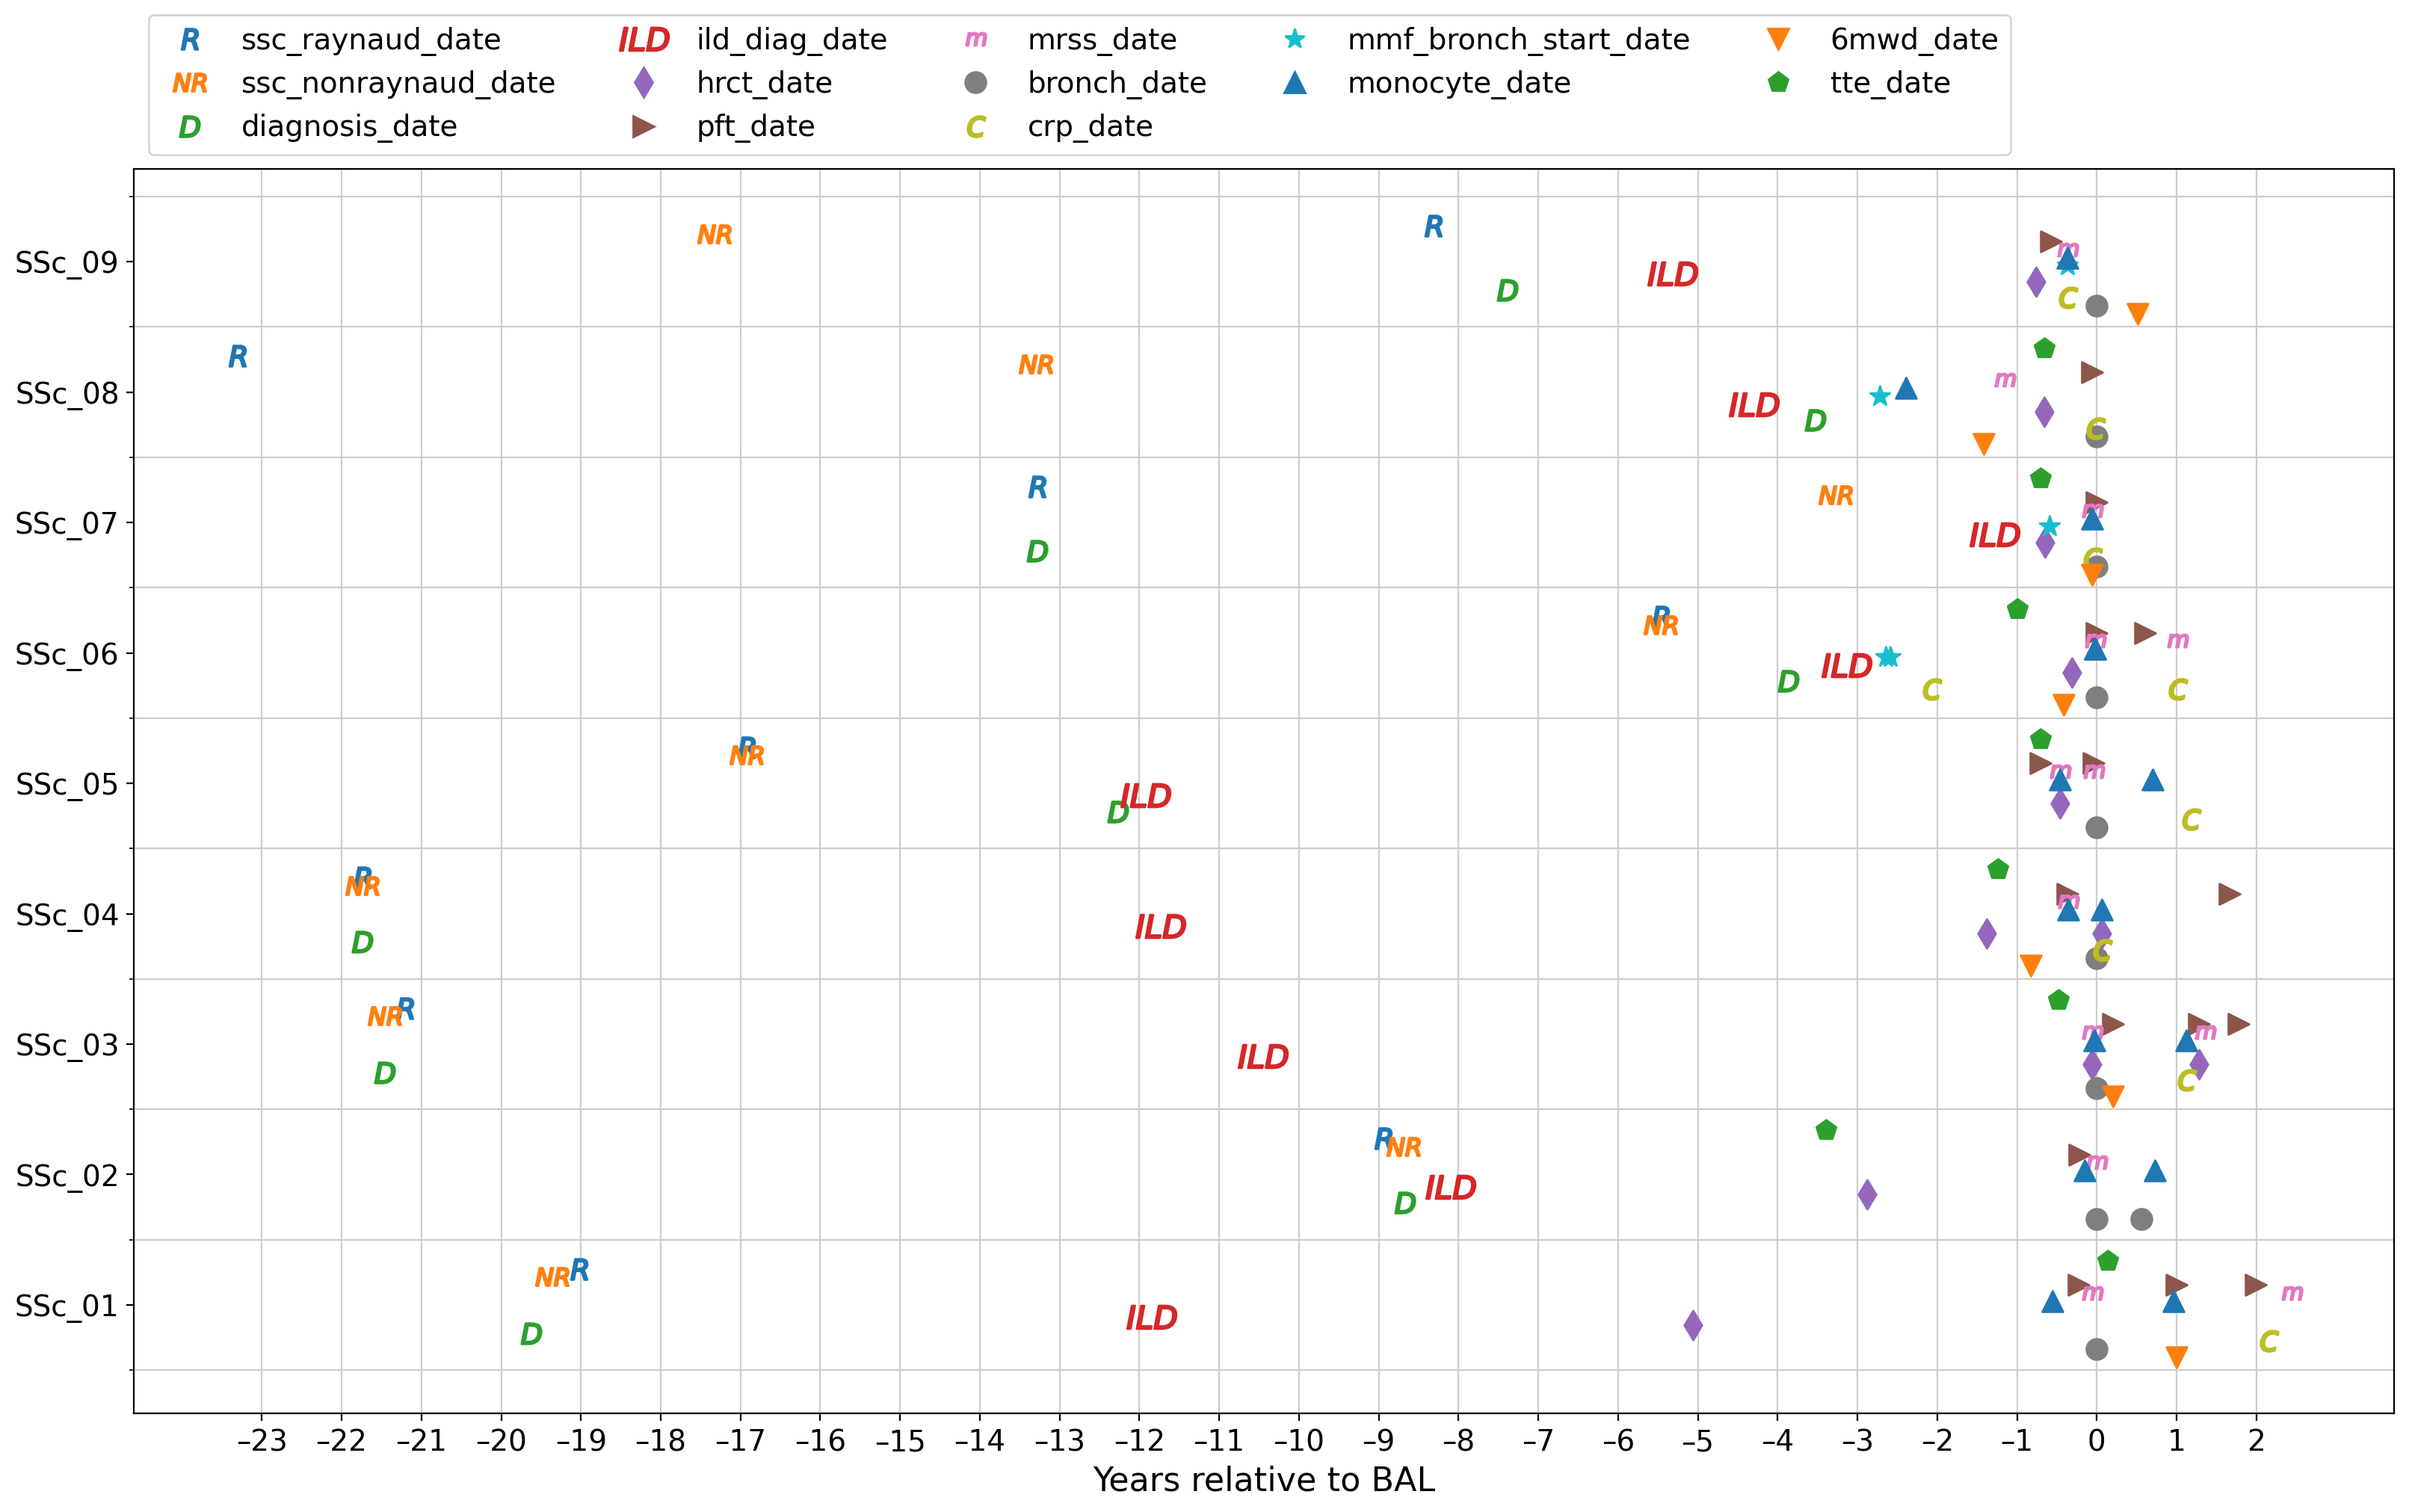

In [43]:
fig, ax = plt.subplots(figsize=(16, 10), constrained_layout=True)
legend_markers = []
legend_labels = []
for event, marker in EVENT_MARKERS.items():
    subset = date_info.loc[date_info.marker.eq(marker)]
    if subset.shape[0] == 0:
        continue
    marker_adj = -0.8 + event_step * subset.event.cat.codes.iloc[0]
    marker_size = 10
    if marker.startswith("$") and len(marker) > 3:
        marker_size = marker_size * (len(marker) - 2) * 0.8
    pc = ax.scatter(
        subset.date_rel,
        subset.paper_id.cat.codes * 2 + marker_adj,
        marker=marker,
        s=marker_size ** 2,
        zorder=2
    )
    legend_markers.append(
        mpl.lines.Line2D(
            [0],
            [0],
            marker=marker,
            markeredgecolor=pc.get_edgecolor(),
            markerfacecolor=pc.get_edgecolor(),
            color="white",
            markersize=marker_size
        )
    )
    legend_labels.append(event)

year = 365
multiplier = 1
ticks = [(0, 0)]
min_date = date_info.date_rel.min() - 50
max_date = date_info.date_rel.max() + 50
cur_date = [year * multiplier, multiplier]
while cur_date[0] <= max_date:
    ticks.append(tuple(cur_date))
    cur_date[0] += year * multiplier
    cur_date[1] += multiplier
cur_date = [-year * multiplier, -multiplier]
while cur_date[0] >= min_date:
    ticks.append(tuple(cur_date))
    cur_date[0] -= year * multiplier
    cur_date[1] -= multiplier
ticks = list(sorted(ticks))
ax.set_xticks([x[0] for x in ticks])
ax.set_xticklabels([str(x[1]).replace("-", "–") for x in ticks], size=14)
ax.grid(c="#ccc", axis="x", zorder=0)
ax.set_xlabel("Years relative to BAL", size=16)
ax.set_yticks(range(0, len(date_info.paper_id.cat.categories) * 2, 2))
ax.set_yticklabels(date_info.paper_id.cat.categories, size=14)
ax.set_yticks(range(-1, len(date_info.paper_id.cat.categories) * 2, 2), minor=True)
ax.grid(c="#ccc", axis="y", which="minor", zorder=0)
ax.legend(
    legend_markers,
    legend_labels,
    loc="lower left",
    bbox_to_anchor=(0, 1),
    ncols=5,
    fontsize=14
)
fig.savefig("plots/01timeline-all.pdf")

## 6. Plot a subset of events

Leave out Raynauld, non Raynauld and Diagnosis dates

In [44]:
date_info_subset = date_info.loc[~date_info.event.isin(
    ["ssc_raynaud_date", "ssc_nonraynaud_date", "diagnosis_date"]
)].copy()

In [45]:
date_info_subset.event = date_info_subset.event.cat.remove_unused_categories()

In [46]:
n_events = date_info_subset.event.nunique()

In [47]:
event_step = 1.6 / n_events

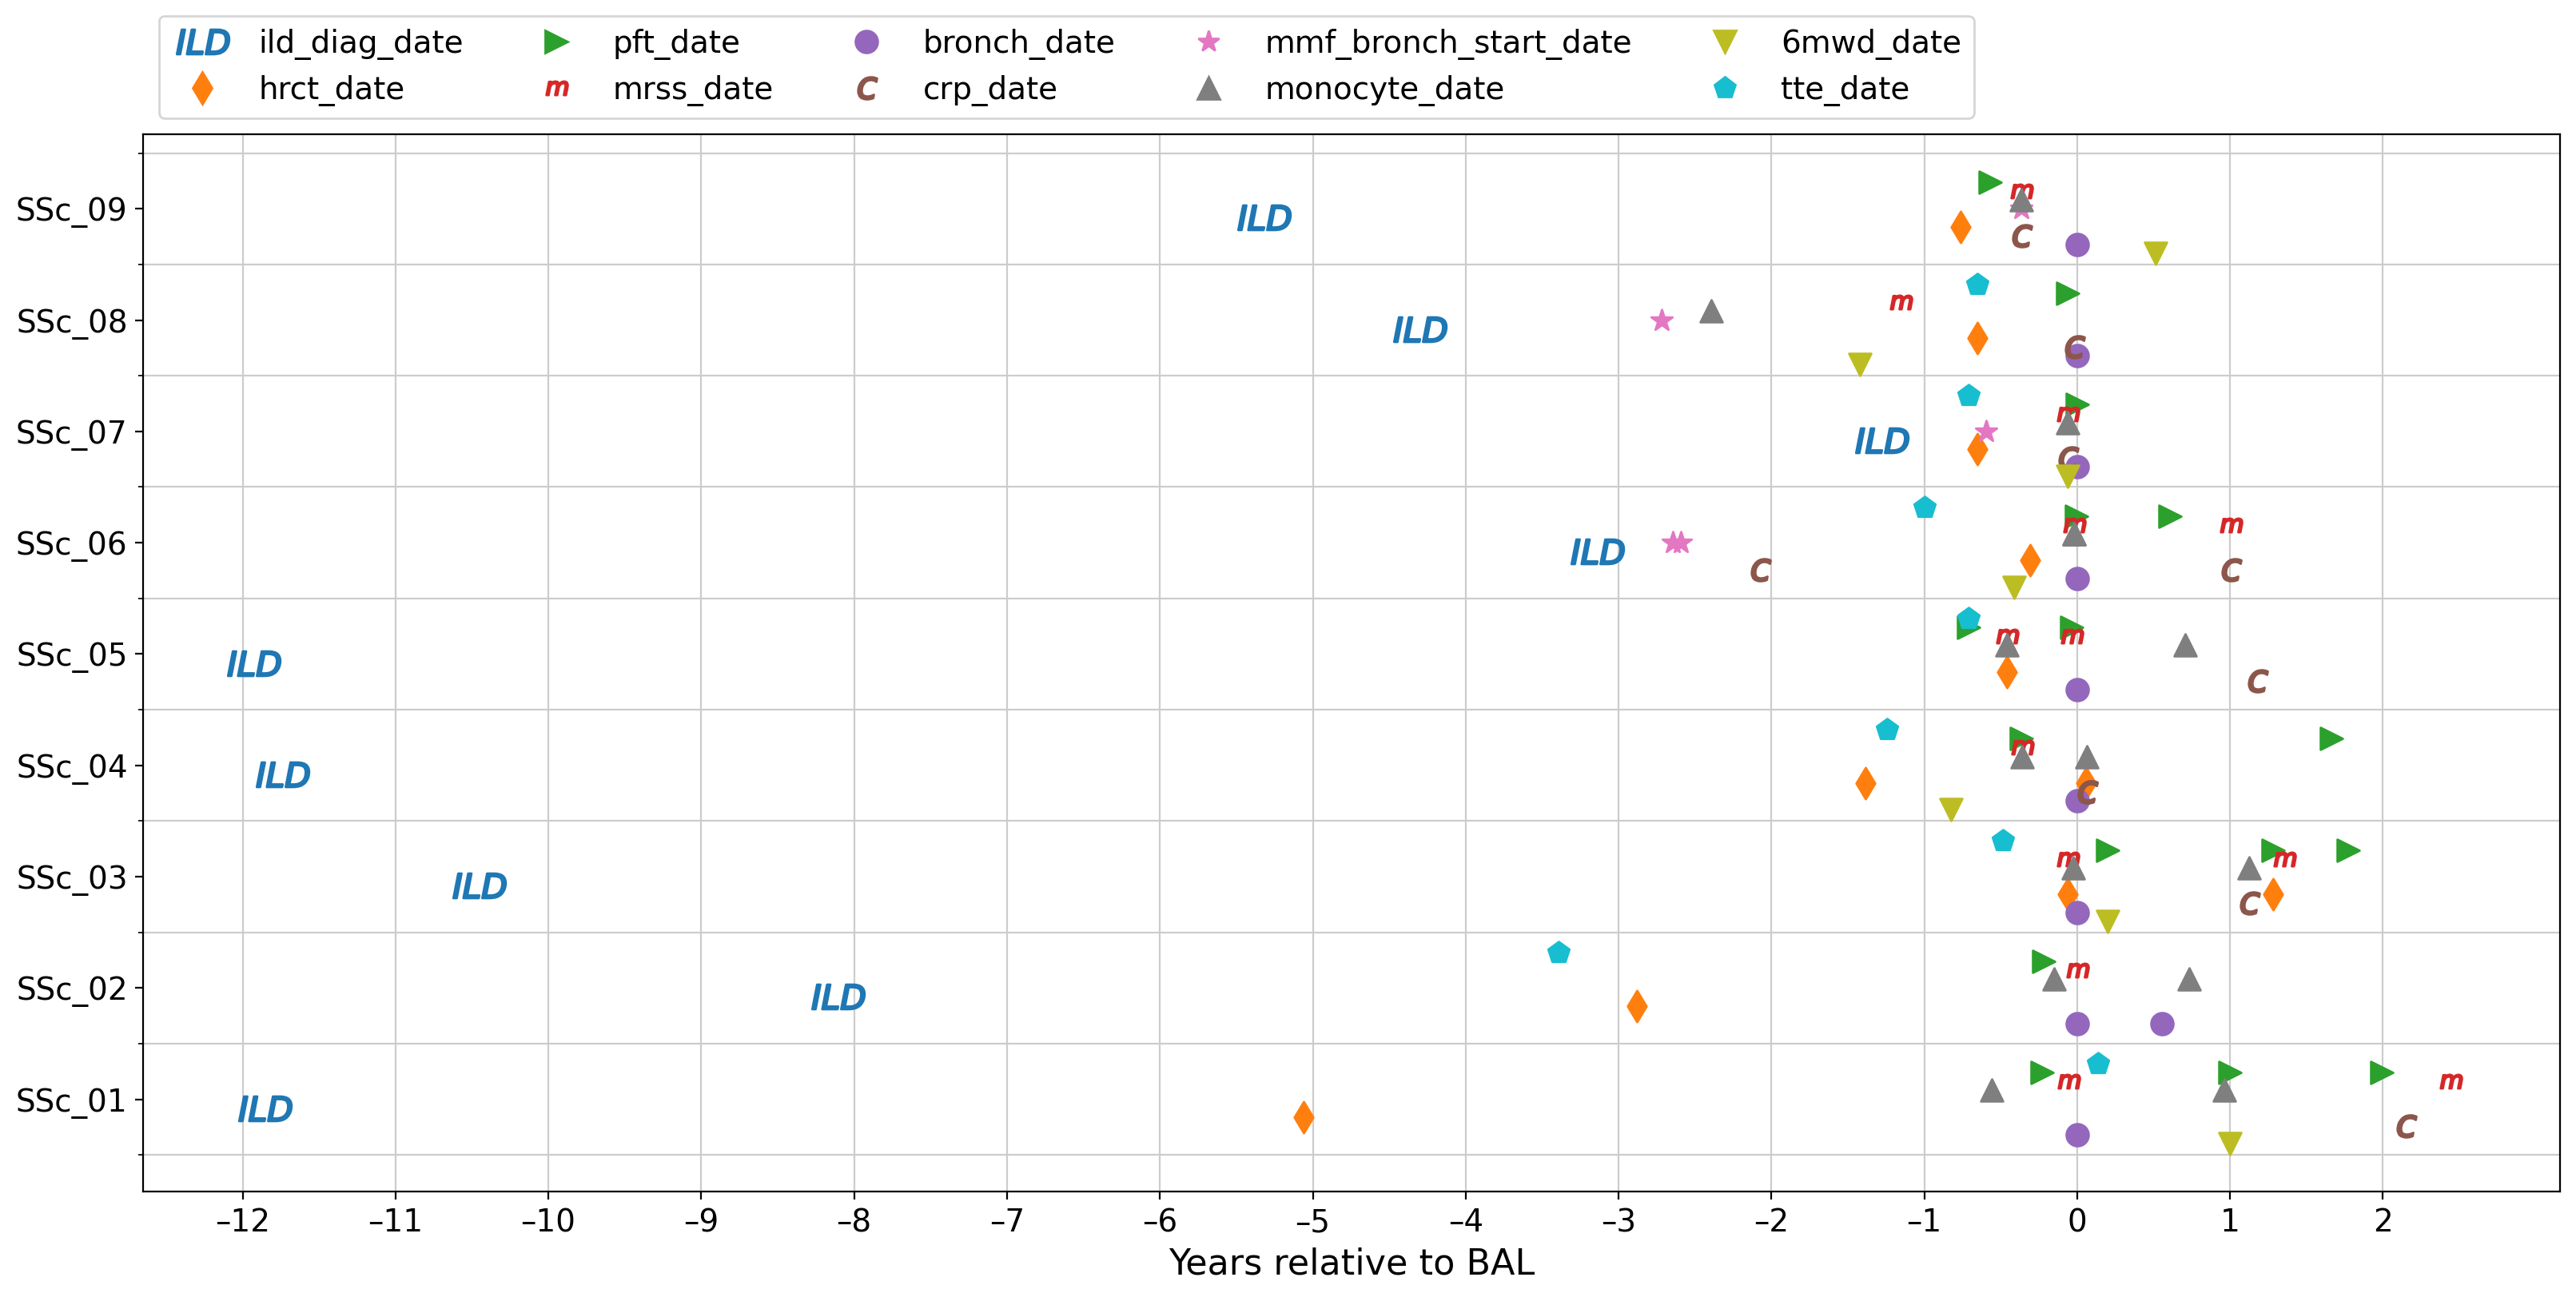

In [48]:
fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
legend_markers = []
legend_labels = []
for event, marker in EVENT_MARKERS.items():
    subset = date_info_subset.loc[date_info_subset.marker.eq(marker)]
    if subset.shape[0] == 0:
        continue
    marker_adj = -0.8 + event_step * subset.event.cat.codes.iloc[0]
    marker_size = 10
    if marker.startswith("$") and len(marker) > 3:
        marker_size = marker_size * (len(marker) - 2) * 0.8
    pc = ax.scatter(
        subset.date_rel,
        subset.paper_id.cat.codes * 2 + marker_adj,
        marker=marker,
        s=marker_size ** 2,
        zorder=2
    )
    legend_markers.append(
        mpl.lines.Line2D(
            [0],
            [0],
            marker=marker,
            markeredgecolor=pc.get_edgecolor(),
            markerfacecolor=pc.get_edgecolor(),
            color="white",
            markersize=marker_size
        )
    )
    legend_labels.append(event)

year = 365
multiplier = 1
ticks = [(0, 0)]
min_date = date_info_subset.date_rel.min() - 100
max_date = date_info_subset.date_rel.max() + 50
cur_date = [year * multiplier, multiplier]
while cur_date[0] <= max_date:
    ticks.append(tuple(cur_date))
    cur_date[0] += year * multiplier
    cur_date[1] += multiplier
cur_date = [-year * multiplier, -multiplier]
while cur_date[0] >= min_date:
    ticks.append(tuple(cur_date))
    cur_date[0] -= year * multiplier
    cur_date[1] -= multiplier
ticks = list(sorted(ticks))
ax.set_xticks([x[0] for x in ticks])
ax.set_xticklabels([str(x[1]).replace("-", "–") for x in ticks], size=14)
ax.grid(c="#ccc", axis="x", zorder=0)
ax.set_xlabel("Years relative to BAL", size=16)
ax.set_yticks(range(0, len(date_info_subset.paper_id.cat.categories) * 2, 2))
ax.set_yticklabels(date_info_subset.paper_id.cat.categories, size=14)
ax.set_yticks(range(-1, len(date_info_subset.paper_id.cat.categories) * 2, 2), minor=True)
ax.grid(c="#ccc", axis="y", which="minor", zorder=0)
ax.legend(
    legend_markers,
    legend_labels,
    loc="lower left",
    bbox_to_anchor=(0, 1),
    ncols=5,
    fontsize=14
)
fig.savefig("plots/01timeline-no-raynaud.pdf")

## 7. Plot a subset of events v2

Leave out ILD date as well

In [49]:
date_info_subset2 = date_info_subset.loc[~date_info_subset.event.isin(
    ["ild_diag_date"]
)].copy()

In [50]:
date_info_subset2.event = date_info_subset2.event.cat.remove_unused_categories()

In [51]:
n_events = date_info_subset2.event.nunique()

In [52]:
event_step = 1.6 / n_events

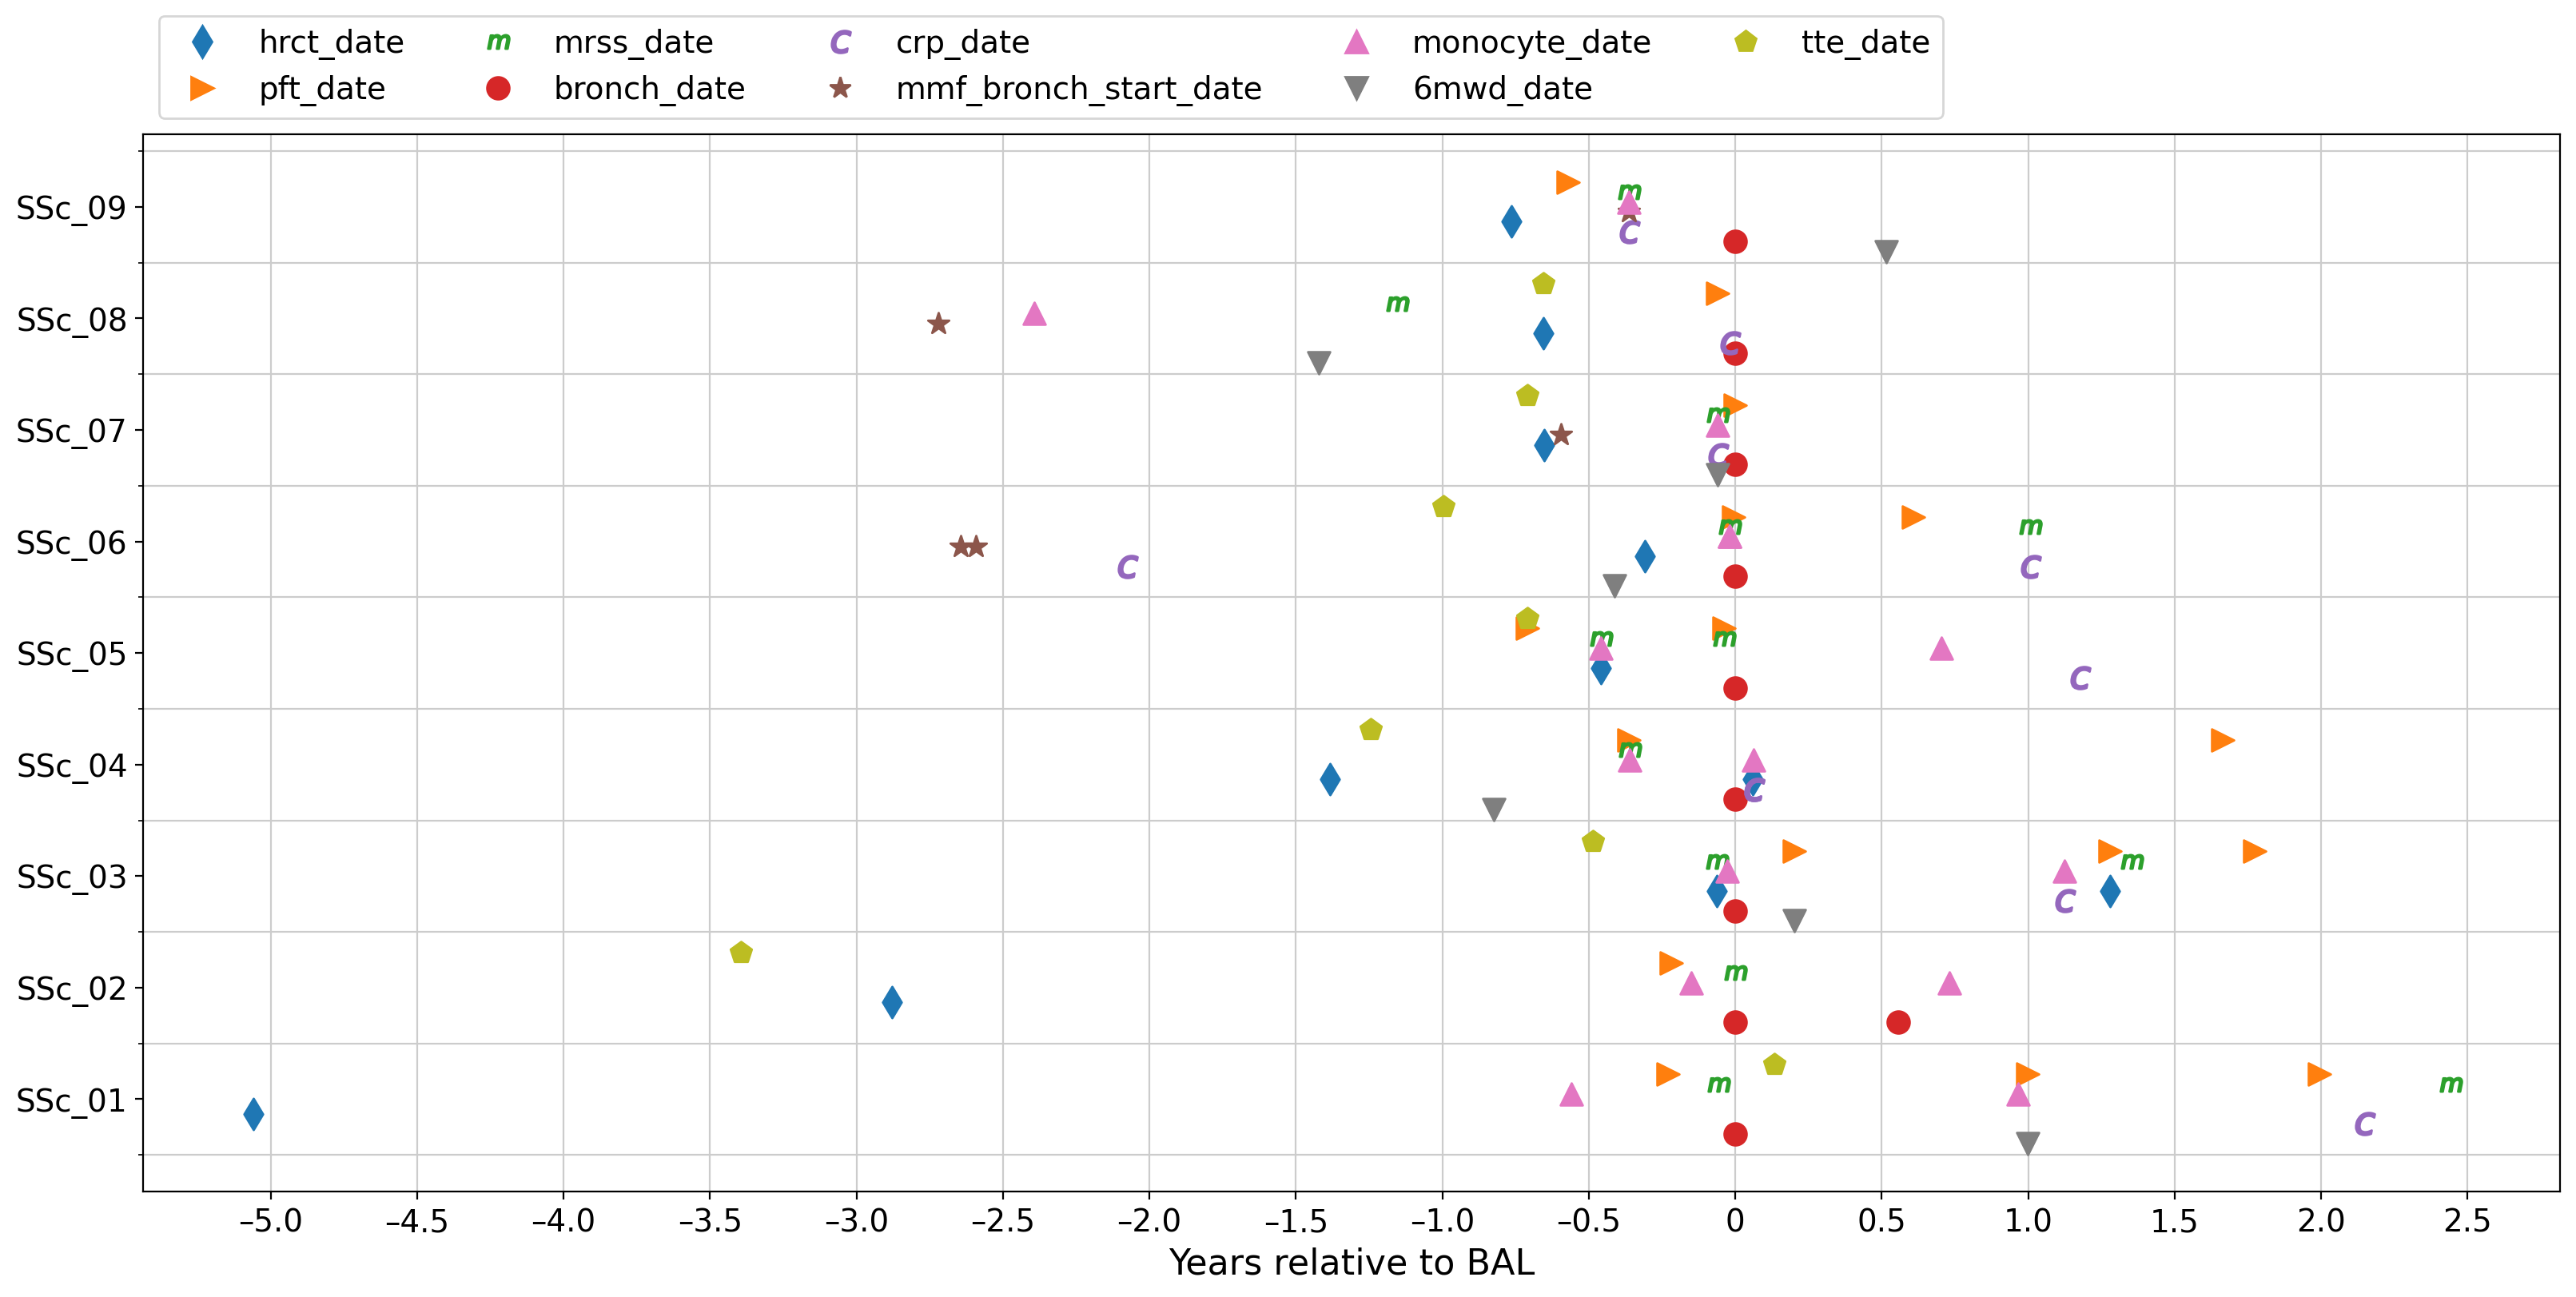

In [53]:
fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
legend_markers = []
legend_labels = []
for event, marker in EVENT_MARKERS.items():
    subset = date_info_subset2.loc[date_info_subset2.marker.eq(marker)]
    if subset.shape[0] == 0:
        continue
    marker_adj = -0.8 + event_step * subset.event.cat.codes.iloc[0]
    marker_size = 10
    if marker.startswith("$") and len(marker) > 3:
        marker_size = marker_size * (len(marker) - 2) * 0.8
    pc = ax.scatter(
        subset.date_rel,
        subset.paper_id.cat.codes * 2 + marker_adj,
        marker=marker,
        s=marker_size ** 2,
        zorder=2
    )
    legend_markers.append(
        mpl.lines.Line2D(
            [0],
            [0],
            marker=marker,
            markeredgecolor=pc.get_edgecolor(),
            markerfacecolor=pc.get_edgecolor(),
            color="white",
            markersize=marker_size
        )
    )
    legend_labels.append(event)

year = 365
multiplier = 0.5
ticks = [(0, 0)]
min_date = date_info_subset2.date_rel.min() - 100
max_date = date_info_subset2.date_rel.max() + 50
cur_date = [year * multiplier, multiplier]
while cur_date[0] <= max_date:
    ticks.append(tuple(cur_date))
    cur_date[0] += year * multiplier
    cur_date[1] += multiplier
cur_date = [-year * multiplier, -multiplier]
while cur_date[0] >= min_date:
    ticks.append(tuple(cur_date))
    cur_date[0] -= year * multiplier
    cur_date[1] -= multiplier
ticks = list(sorted(ticks))
ax.set_xticks([x[0] for x in ticks])
ax.set_xticklabels([str(x[1]).replace("-", "–") for x in ticks], size=14)
ax.grid(c="#ccc", axis="x", zorder=0)
ax.set_xlabel("Years relative to BAL", size=16)
ax.set_yticks(range(0, len(date_info_subset2.paper_id.cat.categories) * 2, 2))
ax.set_yticklabels(date_info_subset2.paper_id.cat.categories, size=14)
ax.set_yticks(range(-1, len(date_info_subset2.paper_id.cat.categories) * 2, 2), minor=True)
ax.grid(c="#ccc", axis="y", which="minor", zorder=0)
ax.legend(
    legend_markers,
    legend_labels,
    loc="lower left",
    bbox_to_anchor=(0, 1),
    ncols=5,
    fontsize=14
)
fig.savefig("plots/01timeline-no-ild.pdf")

## 8. Figure plot

Only keep HRCT, PFT, Bronch, MMF.

For double MMF, keep the first one.
For others, keep the closest one to bronch, remove others

In [59]:
# maybe add `ild_diag_date` ?
date_info_subset3 = date_info.loc[date_info.event.isin(
    ['hrct_date', 'pft_date', 'mmf_bronch_start_date', 'bronch_date']
)].copy()

In [60]:
date_info_subset3.event = date_info_subset3.event.cat.remove_unused_categories()

In [61]:
for event in date_info_subset3.event.unique():
    for pt in date_info_subset3.paper_id.unique():
        idx = date_info_subset3.event.eq(event) & date_info_subset3.paper_id.eq(pt)
        if idx.sum() < 2:
            continue
        if event == 'bronch_date':
            continue
        if event == 'mmf_bronch_start_date':
            to_drop = date_info_subset3.loc[idx].sort_values('date').index[1:]
        else:
            to_drop = date_info_subset3.loc[idx].sort_values('date_rel', key=lambda x: x.abs()).index[1:]
        date_info_subset3.drop(index=to_drop, inplace=True)
        print(f'Dropped {len(to_drop)} rows for {event} {pt}')

Dropped 1 rows for hrct_date SSc_04
Dropped 1 rows for hrct_date SSc_03
Dropped 1 rows for pft_date SSc_04
Dropped 1 rows for pft_date SSc_05
Dropped 2 rows for pft_date SSc_03
Dropped 1 rows for pft_date SSc_06
Dropped 2 rows for pft_date SSc_01
Dropped 1 rows for mmf_bronch_start_date SSc_06


In [62]:
n_events = date_info_subset3.event.nunique()

In [63]:
event_step = 1.6 / n_events

In [64]:
class HandlerText(mpl.legend_handler.HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):
        text = mpl.text.Text(
            x=(xdescent + width) / 2,
            y=(ydescent + height) / 2,
            text=orig_handle.get_text(),
            ha='center',
            va='center'
        )
        text.set_transform(trans)
        return [text]

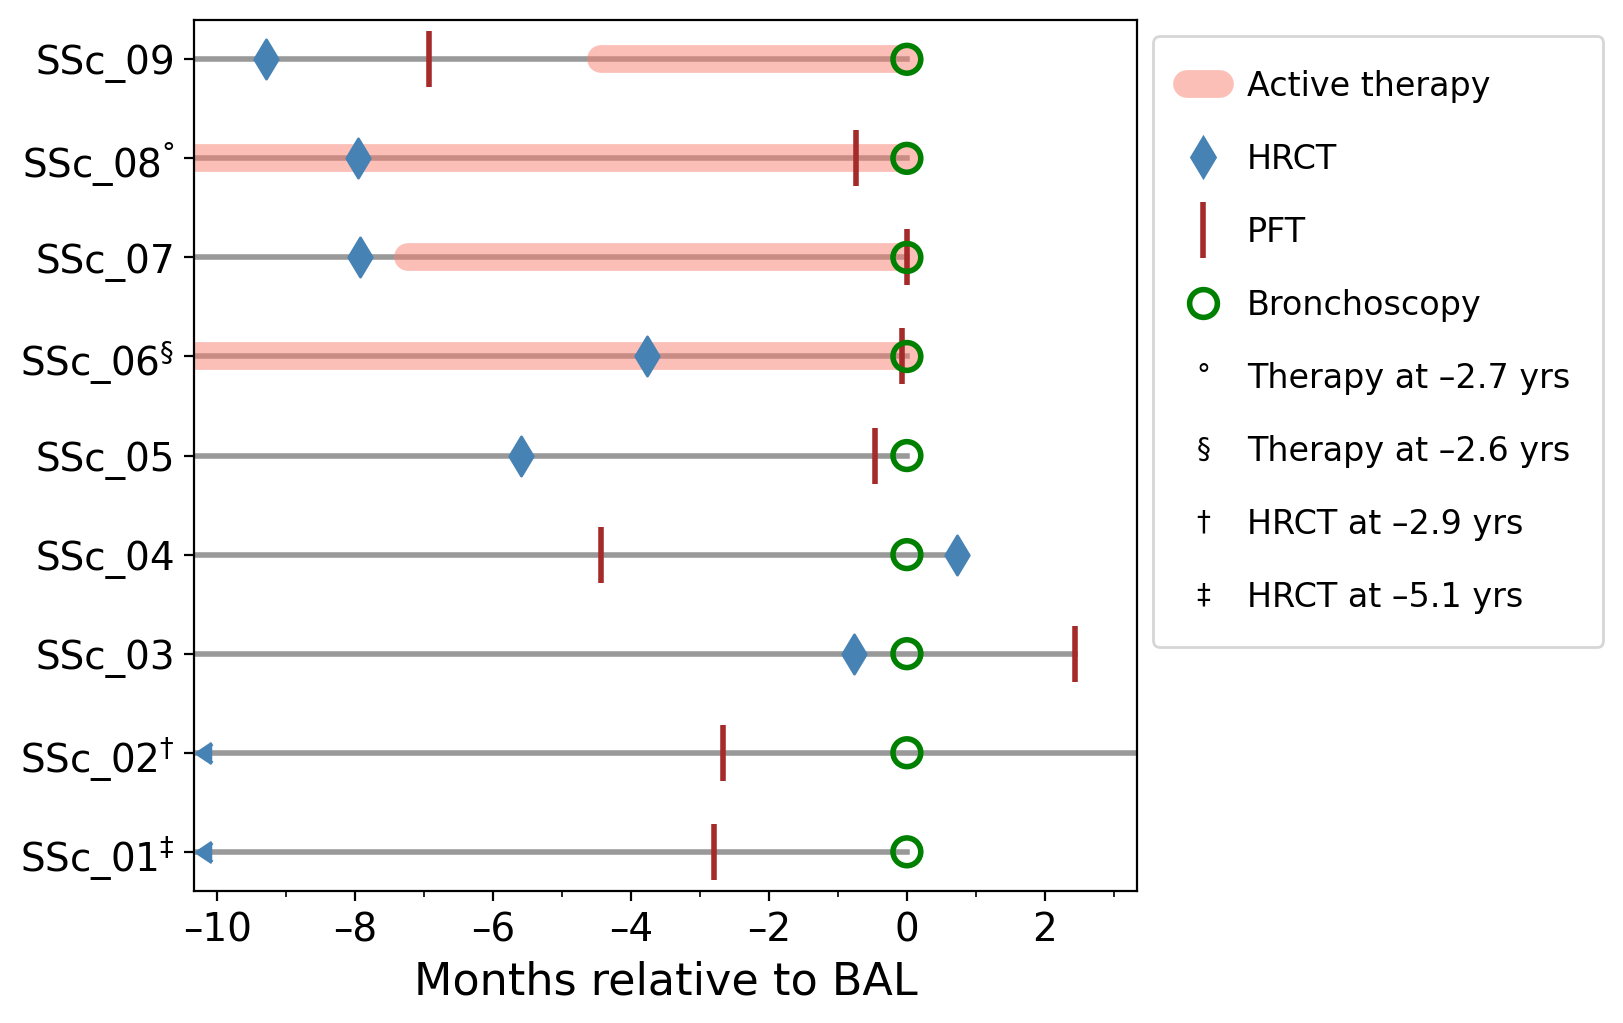

In [65]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
plot_df = date_info_subset3
MIN_DT = -310
legend_markers = [
    mpl.lines.Line2D(
        [0],
        [0],
        color='salmon',
        alpha=0.5,
        lw=10,
        solid_capstyle='round'
    )
]
legend_labels = [
    'Active therapy'
]

for pt in plot_df.paper_id.unique():
    idx = plot_df.paper_id.eq(pt)
    max_dt = plot_df.date_rel[idx].max()
    pt_y = plot_df.paper_id.cat.categories.get_loc(pt) * 2
    ax.plot([-10000, max_dt], [pt_y, pt_y], c='#999', lw=2)
    idx2 = plot_df.event.eq('mmf_bronch_start_date')
    if idx2[idx].sum() == 0:
        continue
    mmf_start = plot_df.date_rel[idx & idx2].min()
    ax.plot([mmf_start, max_dt], [pt_y, pt_y], c='salmon', lw=10, alpha=0.5, solid_capstyle='round')

for event in plot_df.event.unique():
    subset = plot_df.loc[plot_df.event.eq(event)]
    kwargs = {
        'zorder': 2,
        's': 100
    }
    if event == 'bronch_date':
        kwargs['edgecolor'] = 'g'
        kwargs['facecolor'] = 'none'
        kwargs['linewidths'] = 2
        kwargs['marker'] = 'o'
        label = 'Bronchoscopy'
    if event == 'pft_date':
        kwargs['facecolor'] = 'brown'
        kwargs['linewidths'] = 2
        kwargs['marker'] = '|'
        kwargs['s'] = 400
        label = 'PFT'
    if event == 'hrct_date':
        kwargs['facecolor'] = 'steelblue'
        kwargs['marker'] = 'd'
        label = 'HRCT'
    if event == 'mmf_bronch_start_date':
        continue
    pc = ax.scatter(
        subset.date_rel,
        subset.paper_id.cat.codes * 2,
        **kwargs
    )
    legend_kwargs = dict(
        marker=kwargs['marker'],
        markerfacecolor=kwargs['facecolor'],
        markeredgecolor=kwargs['facecolor'],
        markersize=np.sqrt(kwargs['s'])
    )
    if 'edgecolor' in kwargs:
        legend_kwargs['markeredgecolor'] = kwargs['edgecolor']
    if 'linewidths' in kwargs:
        legend_kwargs['markeredgewidth'] = kwargs['linewidths']

    legend_markers.append(
        mpl.lines.Line2D(
            [0],
            [0],
            color='white',
            **legend_kwargs
        )
    )
    legend_labels.append(label)

yticklabels = [(x, x) for x in date_info_subset3.paper_id.cat.categories]
note_chars = '°§†‡'
for i, (_, r) in enumerate(plot_df.loc[plot_df.date_rel.lt(MIN_DT)].sort_values('paper_id', ascending=False).iterrows()):
    if r.event == 'hrct_date':
        ax.scatter(
            MIN_DT + 1,
            plot_df.paper_id.cat.categories.get_loc(r.paper_id) * 2,
            marker=4,
            facecolor='steelblue',
            s=50,
            zorder=2
        )
        label = 'HRCT'
    if r.event == 'mmf_bronch_start_date':
        label = 'Therapy'
    legend_markers.append(
        mpl.text.Text(text=note_chars[i])
    )
    legend_labels.append(
        f'{label} at {r.date_rel / 365:.1f} yrs'.replace('-', '–')
    )
    for j, (pt, pt_label) in enumerate(yticklabels):
        if pt == r.paper_id:
            yticklabels[j] = (pt, f'{pt_label}$^{{\\mathrm{{{note_chars[i]}}}}}$')
            break

month = 30
multiplier = 2
ticks = [(0, 0)]
min_date = date_info_subset3.date_rel.min() - 100
max_date = date_info_subset3.date_rel.max() + 50
cur_date = [month * multiplier, multiplier]
while cur_date[0] <= max_date:
    ticks.append(tuple(cur_date))
    cur_date[0] += month * multiplier
    cur_date[1] += multiplier
cur_date = [-month * multiplier, -multiplier]
while cur_date[0] >= min_date:
    ticks.append(tuple(cur_date))
    cur_date[0] -= month * multiplier
    cur_date[1] -= multiplier
ticks = list(sorted(ticks))
ax.set_xticks([x[0] for x in ticks])
ax.set_xticks([x[0] + 30 for x in ticks], minor=True)
ax.set_xticklabels([str(x[1]).replace("-", "–") for x in ticks], size=14)
# ax.grid(c="#ccc", axis="x", zorder=0)
ax.set_xlabel("Months relative to BAL", size=16)
ax.set_yticks(range(0, len(date_info_subset3.paper_id.cat.categories) * 2, 2))
ax.set_yticklabels([x[1] for x in yticklabels], size=14)
# ax.set_yticks(range(-1, len(date_info_subset3.paper_id.cat.categories) * 2, 2), minor=True)
# ax.grid(c="#ccc", axis="y", which="minor", zorder=0)
ax.legend(
    legend_markers,
    legend_labels,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncols=1,
    fontsize=12,
    labelspacing=1.2,
    handlelength=1,
    borderpad=1,
    handler_map={mpl.text.Text: HandlerText()}
)
ax.set_xlim(MIN_DT, 100)
fig.savefig("plots/01_Figure_S1A_timeline.pdf")

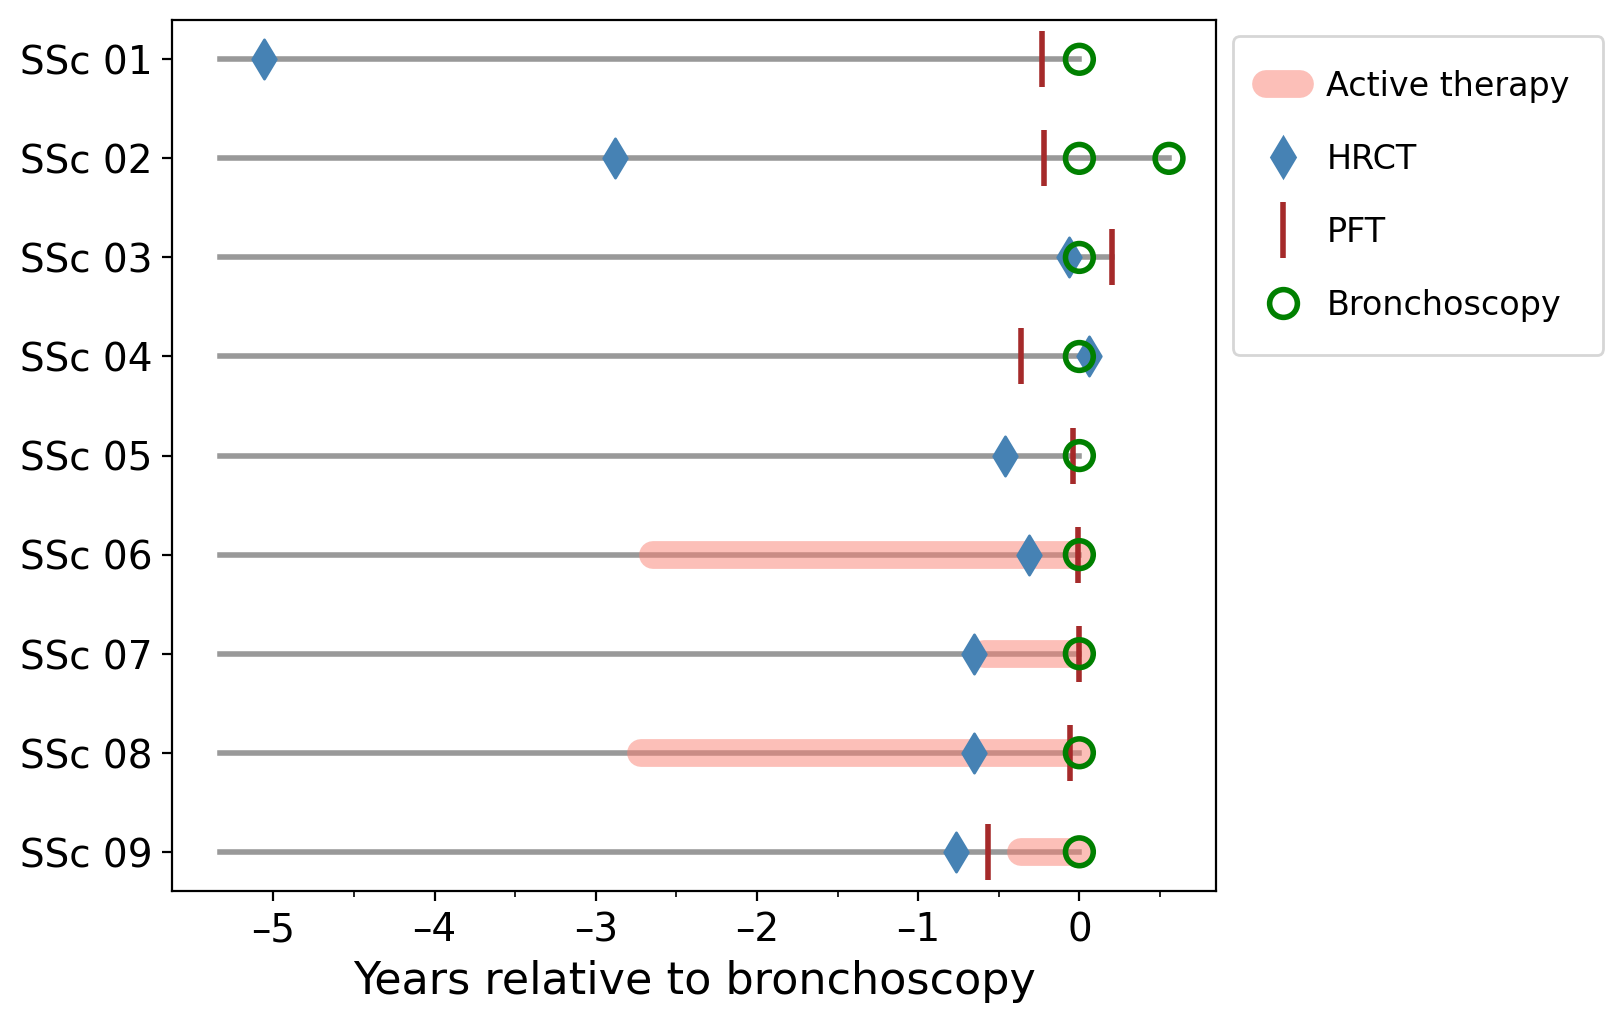

In [66]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
plot_df = date_info_subset3
MIN_DT = -310
legend_markers = [
    mpl.lines.Line2D(
        [0],
        [0],
        color='salmon',
        alpha=0.5,
        lw=10,
        solid_capstyle='round'
    )
]
legend_labels = [
    'Active therapy'
]

for pt in plot_df.paper_id.unique():
    idx = plot_df.paper_id.eq(pt)
    max_dt = plot_df.date_rel[idx].max()
    min_dt = plot_df.date_rel.min() - 100
    pt_y = plot_df.paper_id.cat.categories.get_loc(pt) * 2
    ax.plot([min_dt, max_dt], [pt_y, pt_y], c='#999', lw=2)
    idx2 = plot_df.event.eq('mmf_bronch_start_date')
    if idx2[idx].sum() == 0:
        continue
    mmf_start = plot_df.date_rel[idx & idx2].min()
    ax.plot([mmf_start, max_dt], [pt_y, pt_y], c='salmon', lw=10, alpha=0.5, solid_capstyle='round')

for event in plot_df.event.unique():
    subset = plot_df.loc[plot_df.event.eq(event)]
    kwargs = {
        'zorder': 2,
        's': 100
    }
    if event == 'bronch_date':
        kwargs['edgecolor'] = 'g'
        kwargs['facecolor'] = 'none'
        kwargs['linewidths'] = 2
        kwargs['marker'] = 'o'
        label = 'Bronchoscopy'
    if event == 'pft_date':
        kwargs['facecolor'] = 'brown'
        kwargs['linewidths'] = 2
        kwargs['marker'] = '|'
        kwargs['s'] = 400
        label = 'PFT'
    if event == 'hrct_date':
        kwargs['facecolor'] = 'steelblue'
        kwargs['marker'] = 'd'
        label = 'HRCT'
    if event == 'mmf_bronch_start_date':
        continue
    pc = ax.scatter(
        subset.date_rel,
        subset.paper_id.cat.codes * 2,
        **kwargs
    )
    legend_kwargs = dict(
        marker=kwargs['marker'],
        markerfacecolor=kwargs['facecolor'],
        markeredgecolor=kwargs['facecolor'],
        markersize=np.sqrt(kwargs['s'])
    )
    if 'edgecolor' in kwargs:
        legend_kwargs['markeredgecolor'] = kwargs['edgecolor']
    if 'linewidths' in kwargs:
        legend_kwargs['markeredgewidth'] = kwargs['linewidths']

    legend_markers.append(
        mpl.lines.Line2D(
            [0],
            [0],
            color='white',
            **legend_kwargs
        )
    )
    legend_labels.append(label)

yticklabels = [(x, x) for x in date_info_subset3.paper_id.cat.categories]
# note_chars = '°§†‡'
# for i, (_, r) in enumerate(plot_df.loc[plot_df.date_rel.lt(MIN_DT)].sort_values('paper_id', ascending=False).iterrows()):
#     if r.event == 'hrct_date':
#         ax.scatter(
#             MIN_DT + 1,
#             plot_df.paper_id.cat.categories.get_loc(r.paper_id) * 2,
#             marker=4,
#             facecolor='steelblue',
#             s=50,
#             zorder=2
#         )
#         label = 'HRCT'
#     if r.event == 'mmf_bronch_start_date':
#         label = 'Therapy'
#     legend_markers.append(
#         mpl.text.Text(text=note_chars[i])
#     )
#     legend_labels.append(
#         f'{label} at {r.date_rel / 365:.1f} yrs'.replace('-', '–')
#     )
#     for j, (pt, pt_label) in enumerate(yticklabels):
#         if pt == r.paper_id:
#             yticklabels[j] = (pt, f'{pt_label}$^{{\\mathrm{{{note_chars[i]}}}}}$')
#             break

month = 365
multiplier = 1
ticks = [(0, 0)]
min_date = date_info_subset3.date_rel.min() - 100
max_date = date_info_subset3.date_rel.max() + 50
cur_date = [month * multiplier, multiplier]
while cur_date[0] <= max_date:
    ticks.append(tuple(cur_date))
    cur_date[0] += month * multiplier
    cur_date[1] += multiplier
cur_date = [-month * multiplier, -multiplier]
while cur_date[0] >= min_date:
    ticks.append(tuple(cur_date))
    cur_date[0] -= month * multiplier
    cur_date[1] -= multiplier
ticks = list(sorted(ticks))
ax.set_xticks([x[0] for x in ticks])
ax.set_xticks([x[0] + 365/2 for x in ticks], minor=True)
ax.set_xticklabels([str(x[1]).replace("-", "–") for x in ticks], size=14)
# ax.grid(c="#ccc", axis="x", zorder=0)
ax.set_xlabel("Years relative to bronchoscopy", size=16)
ax.set_yticks(range(0, len(date_info_subset3.paper_id.cat.categories) * 2, 2))
ax.set_yticklabels([x[1].replace('_', ' ') for x in yticklabels], size=14)
# ax.set_yticks(range(-1, len(date_info_subset3.paper_id.cat.categories) * 2, 2), minor=True)
# ax.grid(c="#ccc", axis="y", which="minor", zorder=0)
ax.legend(
    legend_markers,
    legend_labels,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncols=1,
    fontsize=12,
    labelspacing=1.2,
    handlelength=1,
    borderpad=1,
    handler_map={mpl.text.Text: HandlerText()}
)
# ax.set_xlim(MIN_DT, 100)
ax.yaxis.set_inverted(True)
fig.savefig("plots/01_Figure_S1A_timeline_v2.pdf")

## Write out stats for these dates

In [67]:
date_info_subset3.loc[
    date_info_subset3.event.eq('hrct_date')
].date_rel.abs().quantile([0.25, 0.5, 0.75]) / 30

0.25    3.766667
0.50    7.933333
0.75    9.300000
Name: date_rel, dtype: float64

In [68]:
date_info_subset3.loc[
    date_info_subset3.event.eq('pft_date')
].date_rel.abs().quantile([0.25, 0.5, 0.75]) / 30

0.25    0.466667
0.50    2.433333
0.75    2.800000
Name: date_rel, dtype: float64